# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "sdcnd_p2/train.p"
testing_file = "sdcnd_p2/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape
#This is different depending on an image

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

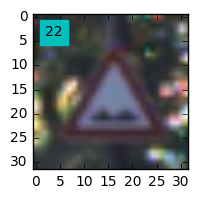

In [3]:
#visualizing image
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(12345)
index = random.randint(0, len(X_train))
image = X_train[index]
plt.figure(figsize=(2,2))
plt.text(2,4,str(y_train[index]),color='k',backgroundcolor='c')
plt.imshow(image)

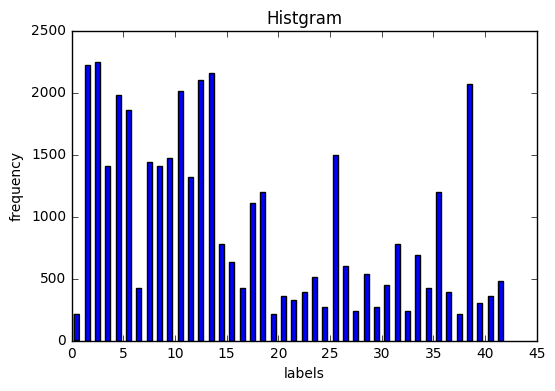

In [4]:
#distribution of data
binwidth = 1
plt.hist(train['labels'],bins=range(min(train['labels']), max(train['labels']) + binwidth, binwidth),rwidth = 0.5)
plt.title("Histgram")
plt.xlabel("labels")
plt.ylabel("frequency")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
#This idea is coming from this post 'https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.abj2tikhw'

import cv2
def normalizing_image(image):
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    image = image/255.-.5
    return image

In [6]:
#Preprocessing data
#These codes are mostly coming from `https://github.com/MehdiSv/TrafficSignsRecognition/`

import scipy.ndimage


print('Preprocessing data...')
# Generate additional data for underrepresented classes
print('Generating additional data...')

train_features = np.array(train['features'])
train_labels = np.array(train['labels'])
X_test = np.array(test['features'])
y_test = np.array(test['labels'])

angles = [-5, 5, -10, 10, -15, 15, -20, 20]
inputs_per_class = np.bincount(train_labels)
max_inputs = np.max(inputs_per_class)

for i in range(len(inputs_per_class)):
#     input_ratio = min(int(max_inputs / inputs_per_class[i]) - 1, len(angles) - 1)
    input_ratio = min(int(round(max_inputs / inputs_per_class[i])) - 1, len(angles) - 1)
    if input_ratio <= 1:
        continue

    new_features = []
    new_labels = []
    mask = np.where(train_labels == i)

    for j in range(input_ratio):
        for feature in train_features[mask]:
            new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_labels.append(i)

    train_features = np.append(train_features, new_features, axis=0)
    train_labels = np.append(train_labels, new_labels, axis=0)


#example a
random.seed(12345)
index = random.randint(0, len(train_features))
pre_norm_bright = train_features[index]
pre_train_features = train_features
nonram_train_labels = train_labels

# Normalizing brightness and features
print('Normalizing brightness and features...')
train_features = np.array([normalizing_image(train_features[i]) for i in range(len(train_features))],
                          dtype = np.float32)
X_test = np.array([normalizing_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)
#example a'
norm_train_features = train_features
normalized_example = train_features[index]

# Get randomized datasets for training and validation
print('Randomizing datasets...')
from sklearn.model_selection import train_test_split
train_features, valid_features, train_labels, valid_labels = train_test_split(
   train_features,
   train_labels,
   test_size=0.2,
   random_state=832289
)

print('Data preprocessed')

Preprocessing data...
Generating additional data...
Normalizing brightness and features...
Randomizing datasets...
Data preprocessed


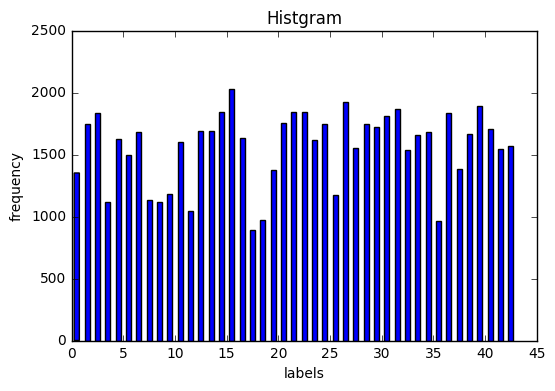

In [7]:
#visualizing preprocessed data
plt.hist(train_labels,bins=range(min(train_labels), max(train_labels)+2 ),rwidth = 0.5)
plt.title("Histgram")
plt.xlabel("labels")
plt.ylabel("frequency")
plt.show()

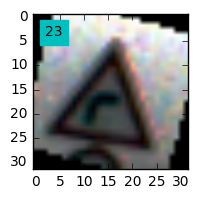

In [8]:
#before normalizing
random.seed(0)
index = random.randint(1,len(nonram_train_labels))
plt.figure(figsize=(2,2))
image = pre_train_features[index]
plt.imshow(image)
plt.text(2,4,str(train_labels[index]),color='k',backgroundcolor='c')

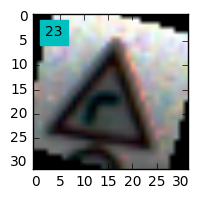

In [9]:
#normalized data example
#becoming a little bit brighter
plt.figure(figsize=(2,2))
image = norm_train_features[index]
plt.imshow(image + .5)
plt.text(2,4,str(train_labels[index]),color='k',backgroundcolor='c')

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I found the distribution of data over class was biased, so I wrote codes to augment data in a way that the unbalanced distribution would be improved. As a result of the augmentation, the distribution of the data is much improved.

I normalized features in a range from -0.5 to 0.5. I also normalized brightness by using cv2.equalizeHist function.

In [10]:
EPOCHS = 500
BATCH_SIZE = 128

In [11]:
import tensorflow as tf
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def dropout_layer(layer, keep_prob):
    layer_drop = tf.nn.dropout(layer, keep_prob)
    return layer_drop

def total_paramators(variable):
    shape = variable.get_shape()[1:]
    variable_paramators = 1
    for dim in shape:
        variable_paramators *= dim.value
    return variable_paramators

In [12]:
# from tensorflow.contrib.layers import flatten

def myNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
   
    
    conv0_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, 3), mean = mu, stddev = np.sqrt(2.0/total_paramators(x))))
    conv0_b = tf.Variable(tf.zeros(3))
    conv0 = tf.nn.conv2d(x, conv0_W, strides=[1, 1, 1, 1], padding='SAME') + conv0_b
    conv0_relu = tf.nn.relu(conv0)
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = np.sqrt(2.0/total_paramators(conv0_relu))))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(conv0_relu, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    conv1_relu = tf.nn.relu(conv1)

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 32), mean = mu, stddev = np.sqrt(2.0/total_paramators(conv1_relu))))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1_relu, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2_relu = tf.nn.relu(conv2)
    conv2_drop = dropout_layer(conv2_relu, keep_prob)
    
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = np.sqrt(2.0/total_paramators(conv2_drop))))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2_drop, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    conv3_relu = tf.nn.relu(conv3)
    
    conv4_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 64), mean = mu, stddev = np.sqrt(2.0/total_paramators(conv3_relu))))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3_relu, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv4_relu = tf.nn.relu(conv4_pool)
    conv4_drop = dropout_layer(conv4_relu, keep_prob)
    
    conv5_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean = mu, stddev = np.sqrt(2.0/total_paramators(conv4_drop))))
    conv5_b = tf.Variable(tf.zeros(128))
    conv5   = tf.nn.conv2d(conv4_drop, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b
    conv5_relu = tf.nn.relu(conv5)
    
    conv6_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 128, 128), mean = mu, stddev = np.sqrt(2.0/total_paramators(conv5_relu))))
    conv6_b = tf.Variable(tf.zeros(128))
    conv6   = tf.nn.conv2d(conv5_relu, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b
    conv6_pool = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv6_relu = tf.nn.relu(conv6_pool)
    conv6_drop = dropout_layer(conv6, keep_prob)
    
    
    #various kinds of connected layer 
    layer_flat2, num_fc_layers2 = flatten_layer(conv2_drop)
    layer_flat4, num_fc_layers4 = flatten_layer(conv4_drop)
    layer_flat6, num_fc_layers6 = flatten_layer(conv6_drop)
    
    #add up to one full connected layer 
    fc0 = tf.concat(1, [layer_flat2, layer_flat4, layer_flat6])
    #total numebr of elements
    num_fc_layers = num_fc_layers2+num_fc_layers4+num_fc_layers6
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(num_fc_layers, 1024), mean = mu, stddev = np.sqrt(2.0/total_paramators(fc0))))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1_relu    = tf.nn.relu(fc1)
    fc1_drop = dropout_layer(fc1_relu, keep_prob)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = np.sqrt(2.0/total_paramators(fc1_drop))))
    fc2_b = tf.Variable(tf.zeros(1024))
    fc2   = tf.matmul(fc1_drop, fc2_W) + fc2_b
    fc2_relu    = tf.nn.relu(fc2)
    fc2_drop = dropout_layer(fc2_relu, keep_prob)
    
    #43 is the number of classes
    fc3_W = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = np.sqrt(2.0/total_paramators(fc2_drop))))
    fc3_b = tf.Variable(tf.zeros(43))
    logits   = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    #regularlization
    regularizers = (tf.nn.l2_loss(conv0_W) 
                + tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) 
                + tf.nn.l2_loss(conv3_W) + tf.nn.l2_loss(conv4_W) 
                + tf.nn.l2_loss(conv5_W) + tf.nn.l2_loss(conv6_W) 
                + tf.nn.l2_loss(fc1_W)  + tf.nn.l2_loss(fc2_W) +
                tf.nn.l2_loss(fc3_W))
    
    return logits, regularizers

In [13]:
#features and labels
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [14]:
#training pipeline
rate = 1e-3
beta = 1e-5

logits, L2_sqr = myNet(x, keep_prob)
# logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy) + beta * L2_sqr
# loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
#model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
from sklearn.utils import shuffle

#for visualization of the accuracy rate 
t_accu = []
v_accu = []


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        training_accuracy = evaluate(X_train, y_train)
        t_accu.append(training_accuracy)
        
        validation_accuracy = evaluate(valid_features, valid_labels)
        v_accu.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'final_net')
    print("Model saved")
    testing_accuracy= evaluate(X_test, y_test)
    print("Testing Accuracy = {:.3f}".format(testing_accuracy))

In [ ]:
#visualization for accuracy rate
plt.title("Accuracy rate")
plt.plot(t_accu)
plt.plot(v_acc)
plt.ylim(.25,1.1)
plt.xlim(0,500)

In [25]:
#f_net has 0.974 test accuracy
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path='f_net')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.974


In [26]:
#making predicted labels for test dataset 
with tf.Session() as sess:
    saver.restore(sess, save_path = 'f_net')
    y_pred = None
    for offset in range(0, len(X_test), BATCH_SIZE):
        batch_x = X_test[offset:offset+BATCH_SIZE]
        pred = sess.run(tf.argmax(logits, 1), feed_dict={x: batch_x, keep_prob:1.0})
        if y_pred == None:
            y_pred  = pred
        else:
            y_pred = np.concatenate((y_pred, pred), axis = 0)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


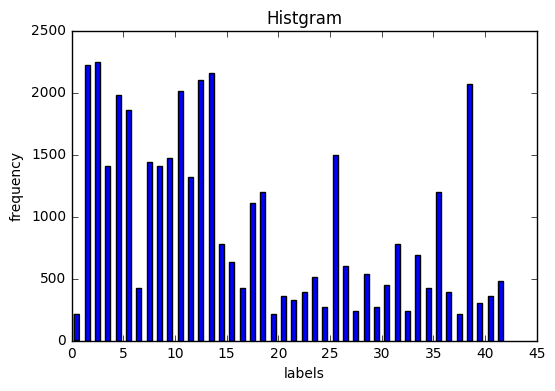

In [18]:
#distribution of testing labels
binwidth = 1
plt.hist(train['labels'],bins=range(min(y_test), max(y_test) + binwidth, binwidth),rwidth = 0.5)
plt.title("Histgram")
plt.xlabel("labels")
plt.ylabel("frequency")
plt.show()

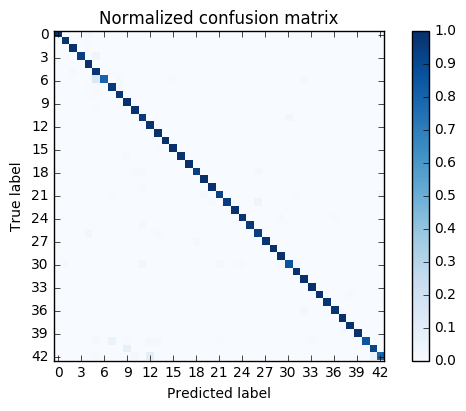

In [19]:
#Since the distribution of testing data is biased, the confusion matrix should be normalized
#Mostly code is coming from 'http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py'

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix




def plot_confusion_matrix(cm, classes = None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.title(title)
    plt.yticks(np.arange(0, 43, 3))
    plt.xticks(np.arange(0, 43, 3))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap , vmin =0, vmax =1)
        plt.colorbar()
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=4)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes='class_names', normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [20]:
#making error bins for a histogram
err_mat = cnf_matrix.tolist()
err_bins = []
for i in range(len(err_mat)):
    err_mat[i].pop(i)
    err_bins.append(sum(err_mat[i]))
    

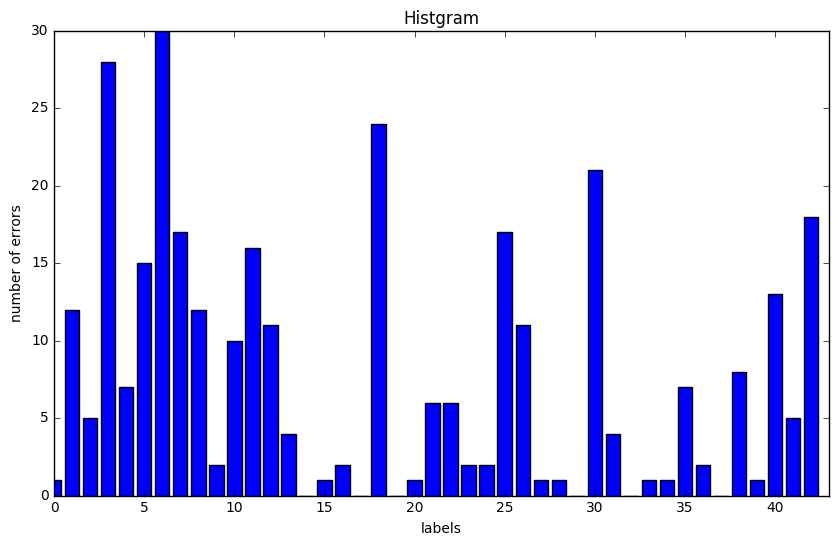

In [21]:
#showing number of erros for each labels in the histogram
plt.figure(figsize=(10,6))
lab = [i for i in range(43)]
plt.bar(lab,err_bins, align="center")
plt.xlim([0,43])
plt.title("Histgram")
plt.xlabel("labels")
plt.ylabel("number of errors")
plt.show()

Number of errors ranking

Ranking 1 ...
End of speed limit (80km/h)
30 errors

Ranking 2 ...
Speed limit (60km/h)
28 errors

Ranking 3 ...
General caution
24 errors

Ranking 4 ...
Beware of ice/snow
21 errors

Ranking 5 ...
End of no passing by vehicles over 3.5 metric tons
18 errors



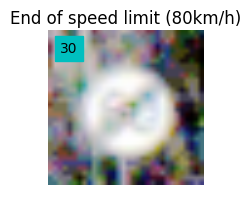

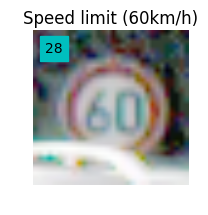

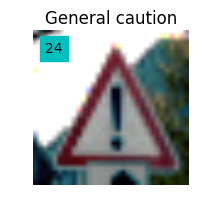

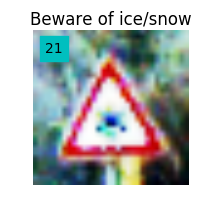

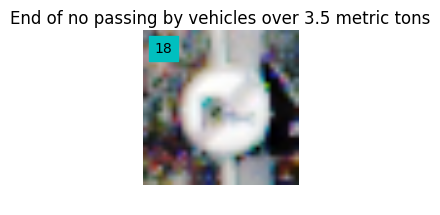

In [22]:
import pandas as pd

data_pd = pd.read_csv('signnames.csv')
err_ranks = list(err_bins)
print ("Number of errors ranking")
print ("")
for i in range(5):
    rank_index = np.argmax(err_ranks)
    print ("Ranking {} ...".format(i+1))
    print (data_pd["SignName"][rank_index])
    print ("{} errors".format(err_ranks[rank_index]))
    print ("")
    
    
    test_list = y_test.tolist()
    index = test_list.index(rank_index)
    image = X_test[index] + .5
    
    
    plt.figure(figsize=(2,2))
    #Top left is the number of errors
    plt.text(2,4,str(err_ranks[rank_index]),color='k',backgroundcolor='c')
    plt.imshow(image)
    plt.axis('off')
    plt.title(data_pd["SignName"][rank_index])
    
    err_ranks[rank_index] = 0
    


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** Testing data is coming from original code(X_test and y_test). All I did here for setting up data was to make validation data. I create validation data from the original training data. So now, the proportion of each data set is 0.6, 0.2, 0.2 in each training data, validation data and testing data. 
As I mentioned in Question 1, I generated the new data so that the biased ditributrion in the original data would be improved.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** My architecture is mostly coming from the blog post written by Vivek Yadev, who is one of the udacity student.

`https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.op0ez044x`

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I chose Adamoptimizer since it is the first choice for an optimizer in terms of the efficiency. Batch size is 128 amd epoch is 500. I could not run anymore because running the model took more than 12 horus. Firat, learning rate was set to relatively high so that the paramators in weight would be optimized quickly, but later I changed more smaller learning rate so that the more accurate score would be achieved. This idea is coming from CS231n lecture. `http://cs231n.github.io/neural-networks-3/` 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I tried many methods to improve score, which includes data normalization, regularlization, CNN architecute, weight initialization and visualization of accuracy rate.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [23]:
def process_newimage_file(name):
    image = cv2.imread(name)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.-.5
    return image

def plot_newImage_3C(n_col,X):

    plt.figure(figsize = (8,6))
    gs1 = gridspec.GridSpec(1,n_col)
    gs1.update(wspace=0.1, hspace=0.02) # set the spacing between axes. 

    for i in range(n_col):
        ax1 = plt.subplot(gs1[i])
        plt.imshow(X[i])
        plt.axis('off')
    plt.show()

In [24]:
import os
import matplotlib.gridspec as gridspec
newdata = [process_newimage_file("./new_signs/"+name) for name in os.listdir("./new_signs/")]
namenewdata = [name for name in os.listdir("./new_signs/")]
newdata = np.array(newdata ,dtype = np.float32)

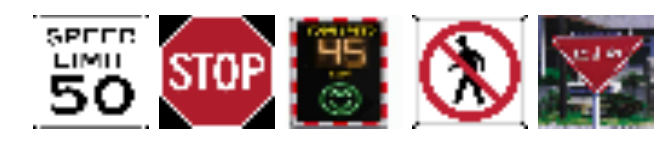

In [25]:
plot_newImage_3C(5,newdata+.5)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** Most new signs are unknow to the model except for the stop sign. In addition, since two speed limit signs contain characters along with figures, they should be difficult to predict for the model.  

In [26]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path='f_net')
    labels_pred = tf.nn.softmax(logits)
    top5 = tf.nn.top_k(labels_pred, 5)
    top5_pred = sess.run(top5, feed_dict={x: newdata, keep_prob:1.0})

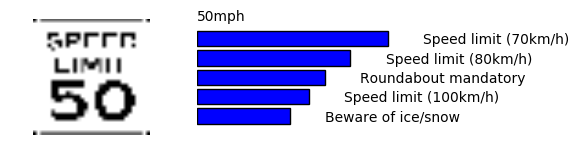

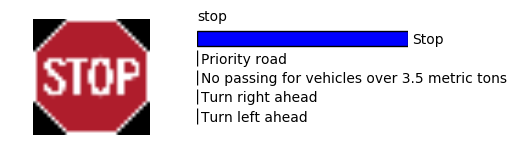

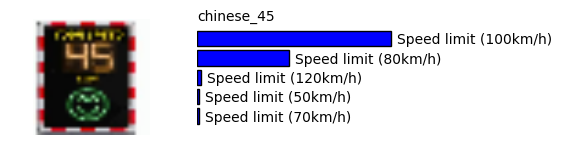

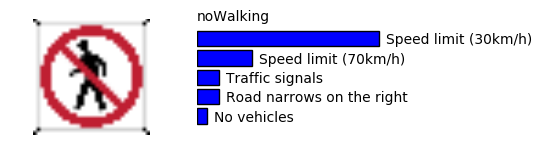

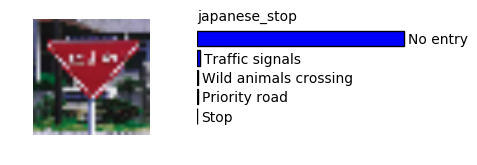

In [27]:
for i in range(5):
    plt.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(newdata[i]+.5)
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6-np.arange(5),top5_pred[0][i], align='center')
    for i_label in range(5):
        plt.text(top5_pred[0][i][i_label]+.02,6-i_label-.25,
            data_pd['SignName'][top5_pred[1][i][i_label]])
    plt.axis('off');
    plt.text(0,6.95,namenewdata[i].split('.')[0]);
    plt.show();

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The model predicted two signs out of five test data, so accuracy rate is 40%. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** The model predicted two signs correctly with high percentage, while the others are predicted poorly. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.